# T2 SME0104 - Cálculo Numérico
## Recomendação de filmes com SVD

Alunos: 
- Kauê Hunnicutt Bazilli - 11212226
- Matheus Vieira Gonçalves - 11200397
- Pedro Henrique dias Junqueira de Souza - 11294312

# Explicação
O projeto desenvolvido foi um decodificador de sinais DTMF, os sinais DTMF são aqueles famosos tons que tocam ao digitarmos números telefônicos, cada número corresponde na verdade a dois tons um de baixa e um de alta frequência que eram decodificados ao chegar na central.

O objetivo do trabalho é criar um decodificador capaz de interpretar o som recebido utilizando o métodos dos mínimos quadrados e converter no som carácter original pressionado.

In [256]:
# Remover os comentários para instalar as bibliotecas necessárias
# import sys
# !{sys.executable} -m pip install sounddevice
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib

import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import sounddevice as sd
import matplotlib.pyplot as pp
import math


Aqui definimos diversas constantes que serão utilizadas ao longo do código

In [297]:

SAMPLE_RATE = 44000  # taxa de gravação
REC_TIME = 10.0  # segundos
FRAMES = int(REC_TIME * SAMPLE_RATE)  # quantidade de frames da gravação
CHANNELS = 1  # quantidade de canais, 1 significa mono

# menor quantidade de tempo significativo durante a gravação
DELTA_T = 1.0 / SAMPLE_RATE

# Frequências DTMF
DTMF_LOW_FREQUENCIES = np.array([697, 770, 852, 941])  # Hz
DTMF_HIGH_FREQUENCIES = np.array([1209, 1336, 1477, 1633])  # Hz

DTMF_FREQUENCIES = np.concatenate(
    [DTMF_LOW_FREQUENCIES, DTMF_HIGH_FREQUENCIES])  # Hz

SILENCE_THRESHOLD_PERCENT = 20
SILENCE_THRESHOLD_PERCENT = (SILENCE_THRESHOLD_PERCENT + 100) / 100

"""
        1209Hz	1336Hz	1477Hz	1633Hz
697Hz	    1	    2	    3	    A
770Hz	    4	    5	    6	    B
852Hz	    7	    8	    9	    C
941Hz	    *	    0	    #	    D
"""

DTMF_DICT = np.array(
    [['1', '2', '3', 'A'],
     ['4', '5', '6', 'B'],
     ['7', '8', '9', 'C'],
     ['*', '0', '#', 'D']])


In [315]:
# inicia a gravação do áudio
sound_wave = sd.rec(frames=FRAMES,
                    samplerate=SAMPLE_RATE,
                    channels=CHANNELS)

sd.wait()  # espera a gravação encerrar
SOUND_WAVE_ROWS, SOUND_WAVE_COLS = sound_wave.shape
print(type(sound_wave), sound_wave.shape)


<class 'numpy.ndarray'> (440000, 1)


In [317]:

sd.play(sound_wave, samplerate=SAMPLE_RATE)  # toca o audio gravado
sd.wait()  # espera o audio encerrar


In [318]:
def reject_outliers(data, m = 3.): #rejeita outliers com base na mediana dos dados
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def moving_average(a, n=1000) : # faz uma média móvel dos dados utilizando uma janela de 1000 dados
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

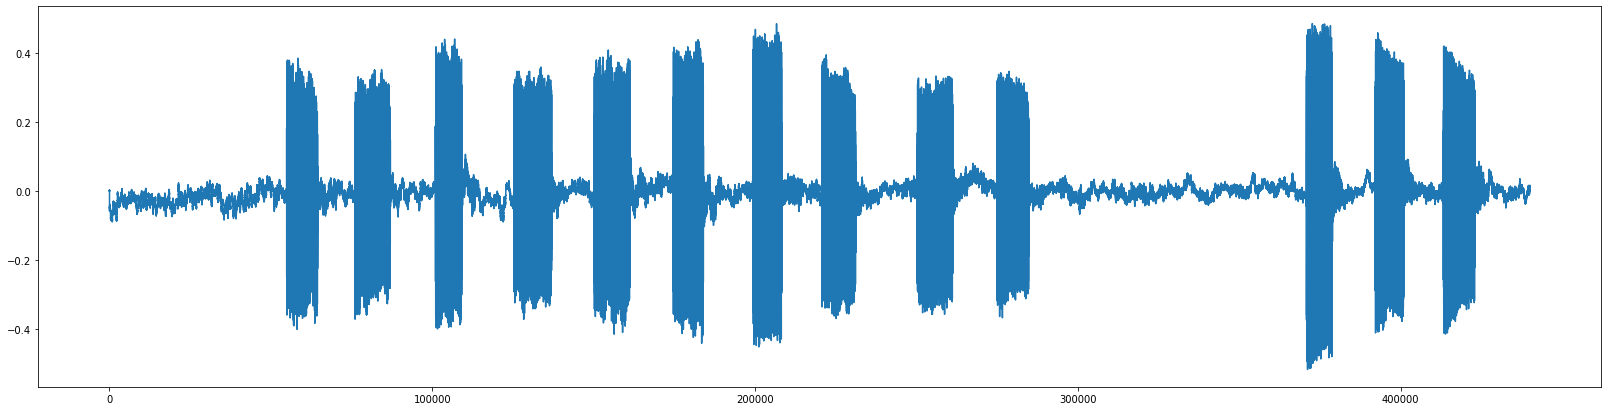

In [319]:
# visualização da gravação
pp.figure(figsize=(28, 7))
pp.plot(sound_wave)
pp.show()


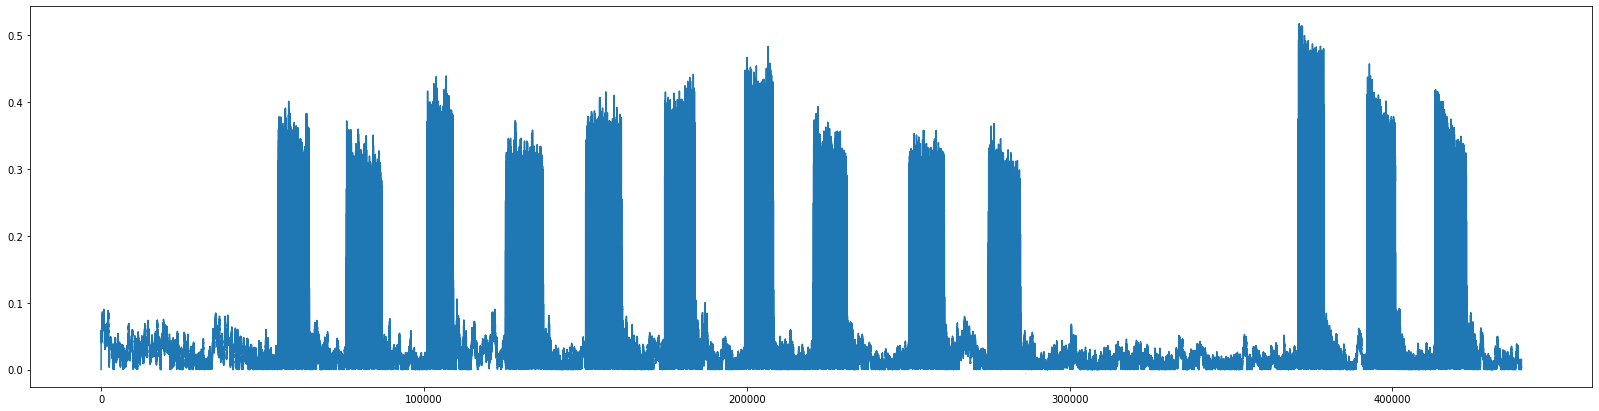

In [320]:
# valores absolutos da gravação
pp.figure(figsize=(28,7))
pp.plot(np.absolute(sound_wave))
pp.show()

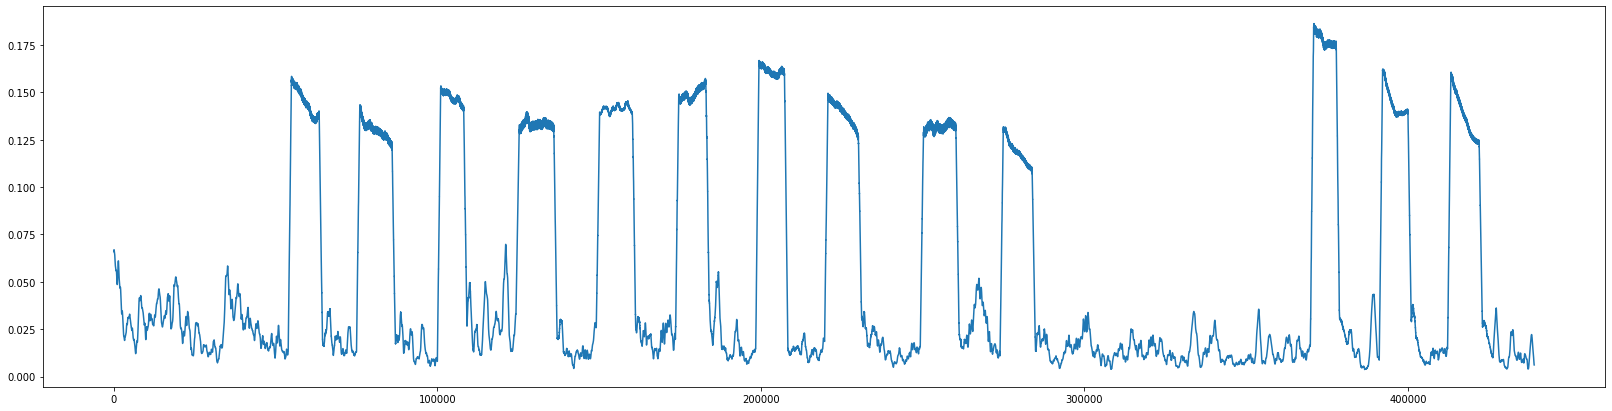

In [322]:
# média móvel dos valores absolutos
filtered_sound_wave = moving_average(np.absolute(sound_wave))

pp.figure(figsize=(28,7))
pp.plot(filtered_sound_wave)
pp.show()

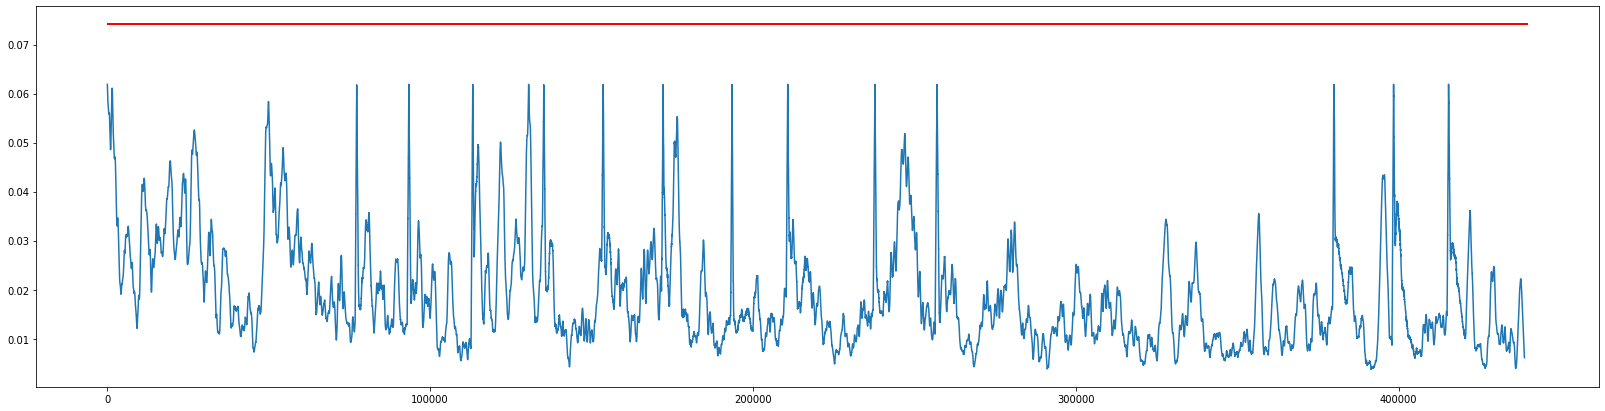

In [324]:
#removendo outliers da média móvel para encontra o threshold dos dados
silence_wave = reject_outliers(filtered_sound_wave)
silence_wave = zoom(silence_wave,len(filtered_sound_wave)/len(silence_wave))

silence_threshold = np.max(silence_wave) * SILENCE_THRESHOLD_PERCENT; #threshold equivalente a 20% a mais que o maior pico do silêncio

pp.figure(figsize=(28,7))
pp.plot(silence_wave)
pp.hlines(silence_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()

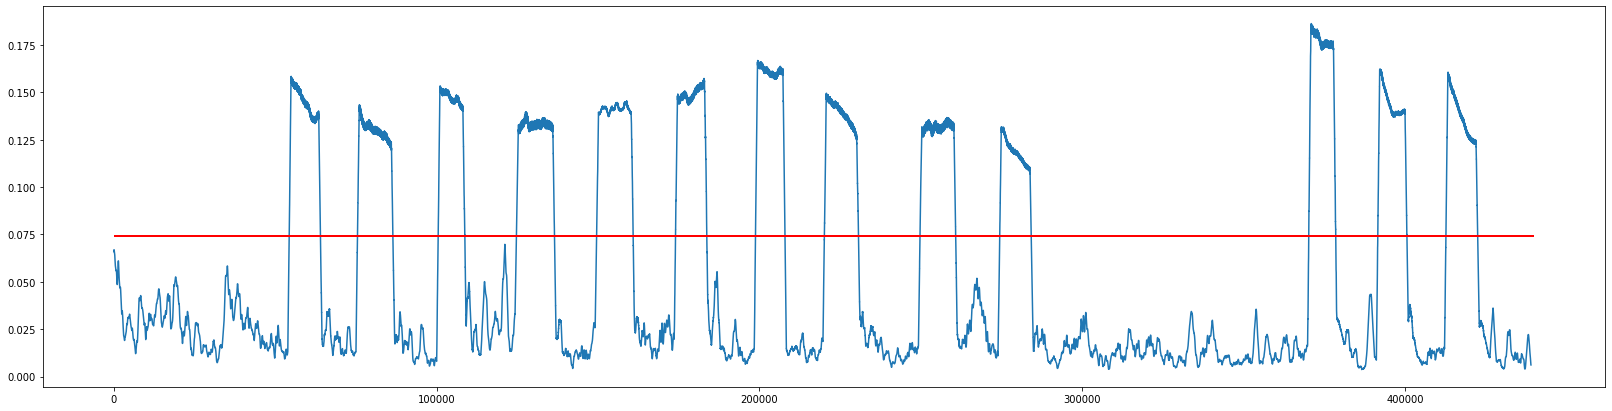

In [326]:
# visualização da média móvel e threshold

pp.figure(figsize=(28,7))
pp.plot(filtered_sound_wave)
pp.hlines(silence_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()


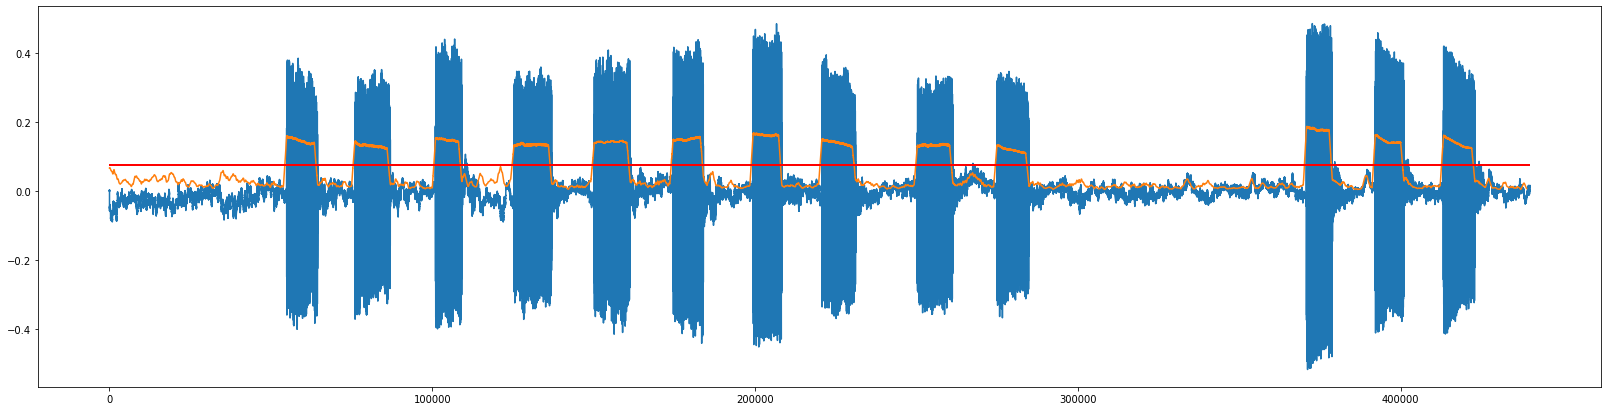

In [328]:
#visualização dos intervalos referentes aos tons capturados
pp.figure(figsize=(28,7))
pp.plot(sound_wave)
pp.plot(filtered_sound_wave)
pp.hlines(silence_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()

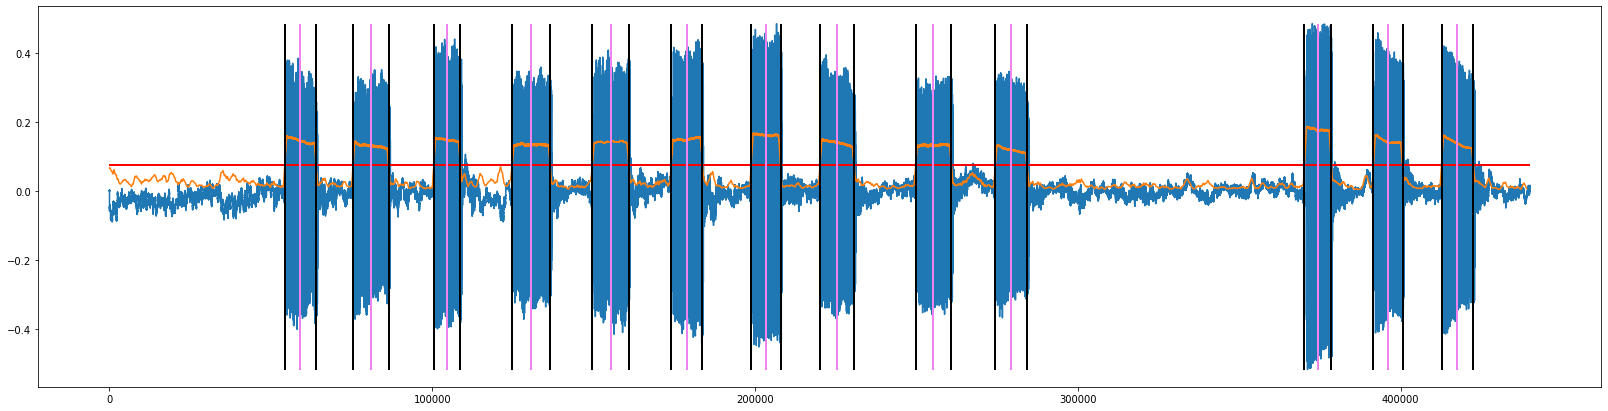

In [329]:
# encontra um intervalo de pontos maior que uma constante
def find_interval(data, max, start=0):
    begin = np.argmax(data[start:] > max)+start
    end = np.argmax(data[begin:] < max)
    return begin, end+begin


# encontra todos os intervalos maiores que uma determinada constante
def find_all_intervals(data, threshold):
    intervals = []
    end = 0
    begin = 0
    while(True):
        begin, end = find_interval(data, threshold, end)
        if end == begin:
            break
        if end - begin > 500:
            intervals.append([begin, end])
    return np.array(intervals)


intervals = find_all_intervals(filtered_sound_wave, silence_threshold)

pp.figure(figsize=(28, 7))
pp.plot(sound_wave)
pp.plot(filtered_sound_wave)
pp.hlines(silence_threshold, xmin=-1,
          xmax=[len(sound_wave)], color='r', linewidth=2)


for begin, end in intervals:
    pp.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='violet', linewidth=2)

pp.show()


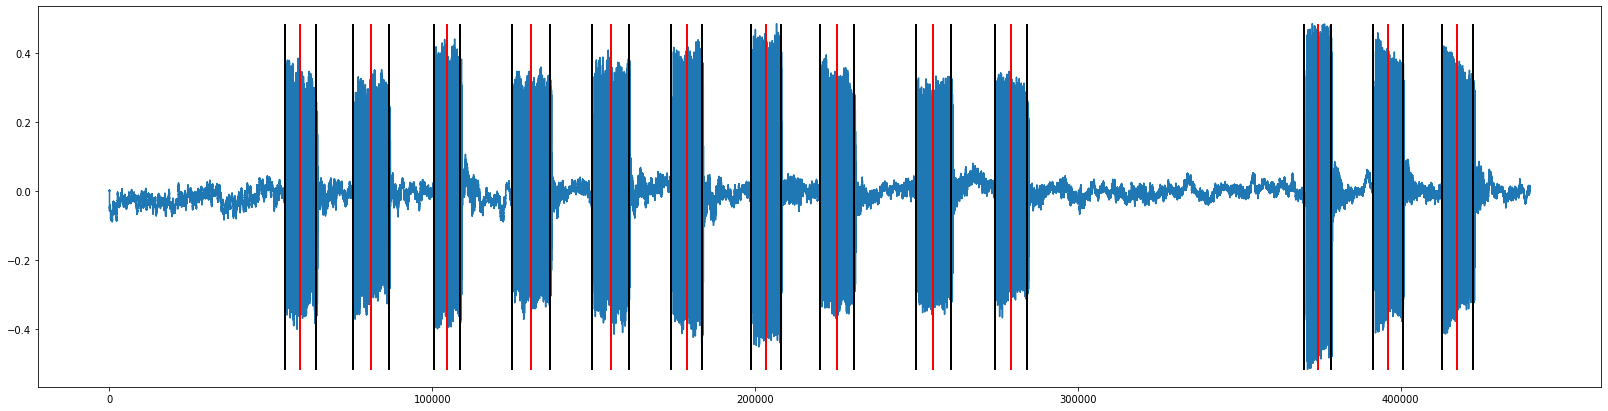

In [331]:
# visualização menos poluída dos dados
pp.figure(figsize=(28, 7))
pp.plot(sound_wave)

for begin, end in intervals:
    pp.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='red', linewidth=2)


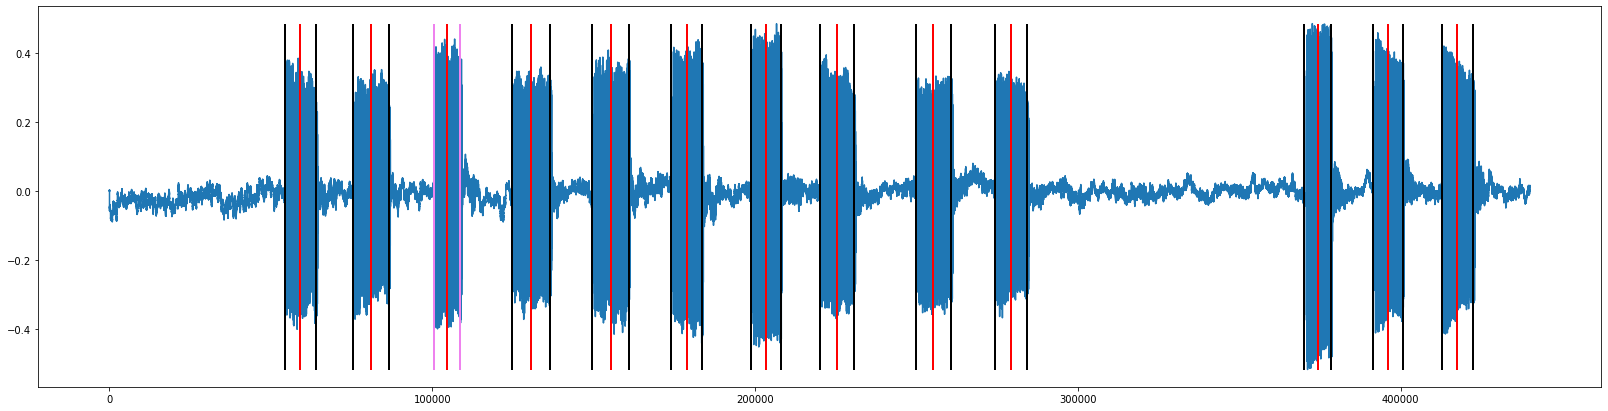

In [335]:
# encontrando o menor dos intervalos
intervals_sizes = [end - begin for begin, end in intervals]
intervals_midpoints = [(end + begin)/2 for begin, end in intervals]

min_interval_idx = np.argmin(intervals_sizes)
MINOR_INTERVAL_SIZE = intervals_sizes[min_interval_idx]

pp.figure(figsize=(28, 7))
pp.plot(sound_wave)
for begin, end in intervals:
    pp.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines((begin+end)/2, ymin=[np.min(sound_wave)],
              ymax=[np.max(sound_wave)], color='red', linewidth=2)

pp.vlines(intervals[min_interval_idx][0], ymin=[np.min(sound_wave)], ymax=[
    np.max(sound_wave)], color='violet', linewidth=2)
pp.vlines(intervals[min_interval_idx][1], ymin=[np.min(sound_wave)], ymax=[
    np.max(sound_wave)], color='violet', linewidth=2)


[[57491, 60839], [79287, 82635], [102935, 106283], [128935, 132283], [153540, 156888], [177162, 180510], [201654, 205002], [223723, 227071], [253583, 256931], [277639, 280987], [372662, 376010], [394384, 397732], [415887, 419235]]


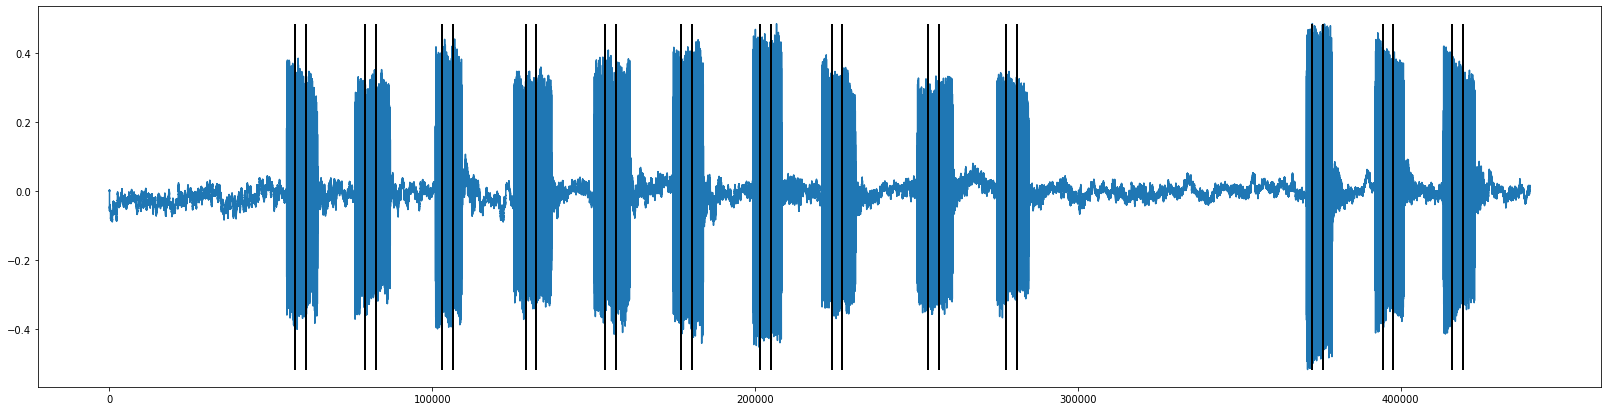

In [336]:
# normalizando os intervalos de acordo com o menor
filtered_intervals = [[int(midpoint - MINOR_INTERVAL_SIZE/2), int(midpoint +
                       MINOR_INTERVAL_SIZE/2)] for midpoint in intervals_midpoints]

print(filtered_intervals)
pp.figure(figsize=(28, 7))
pp.plot(sound_wave)
for begin, end in filtered_intervals:
    pp.vlines(begin, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)
    pp.vlines(end, ymin=[np.min(sound_wave)], ymax=[
              np.max(sound_wave)], color='black', linewidth=2)


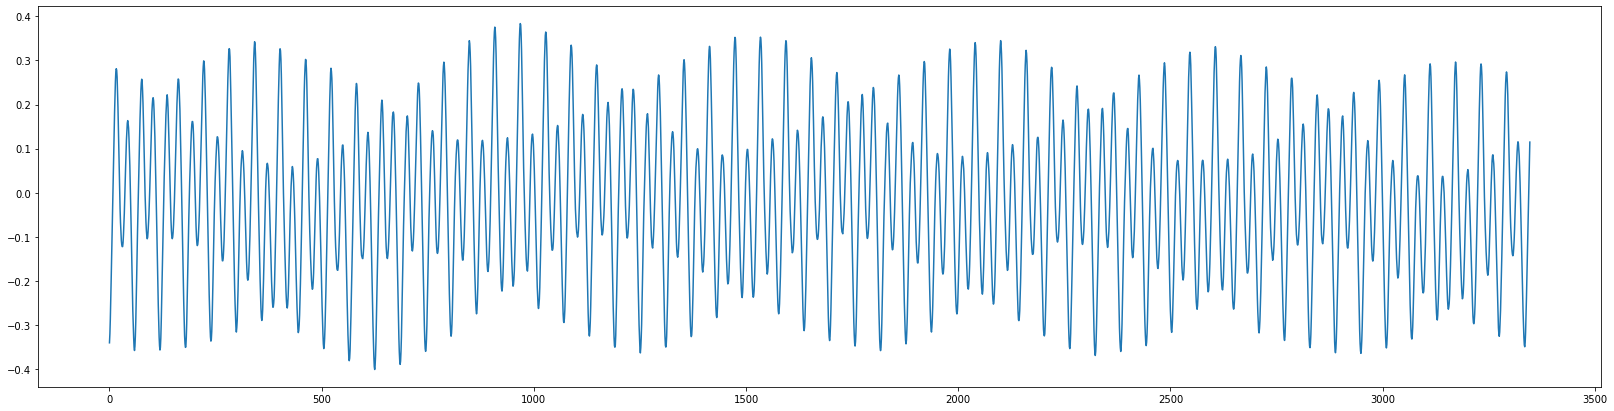

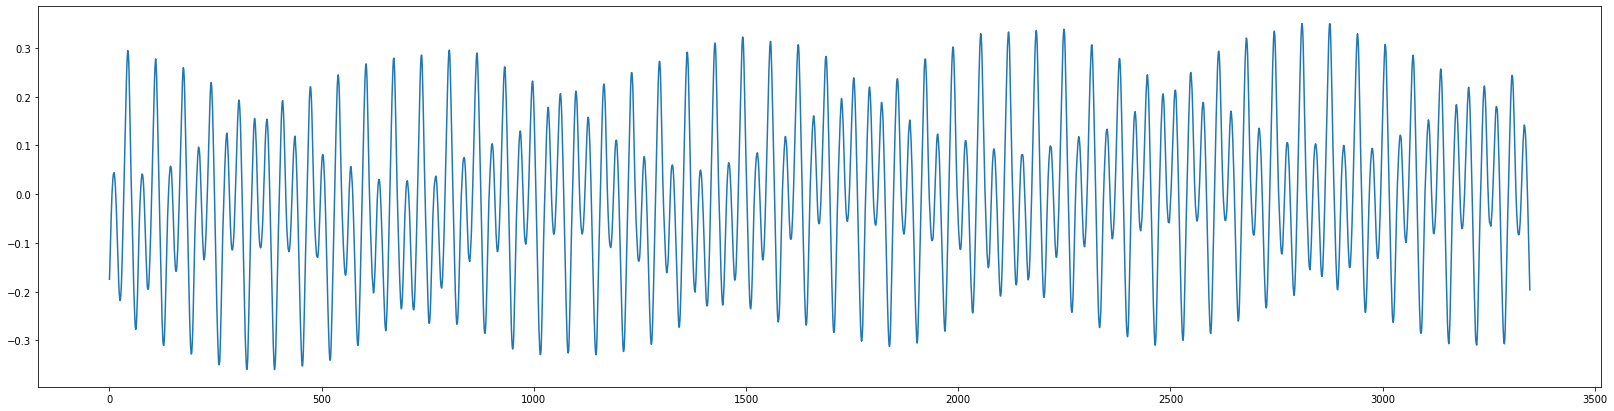

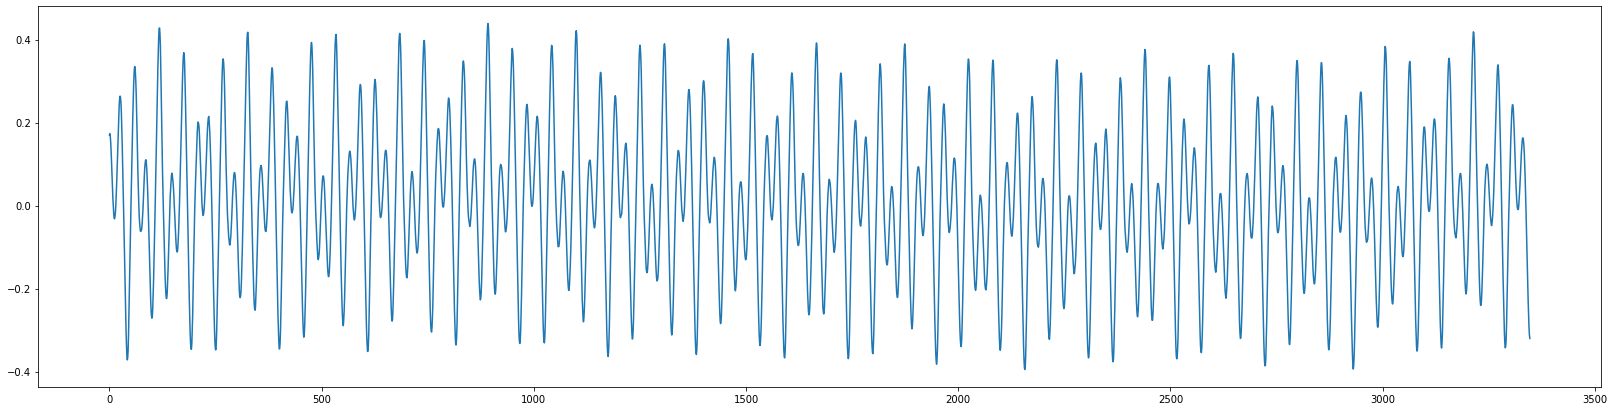

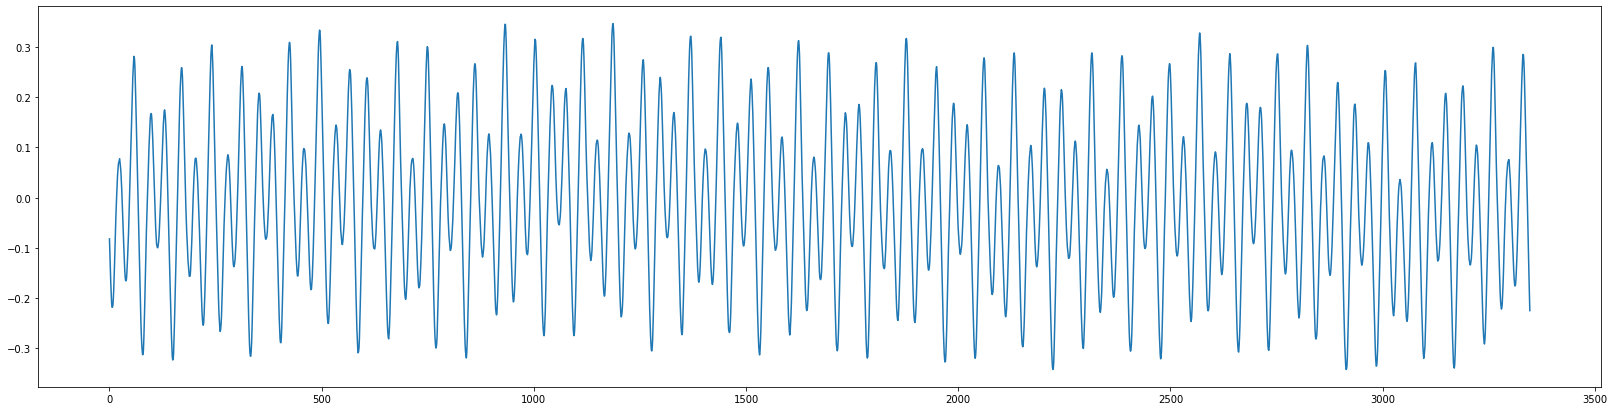

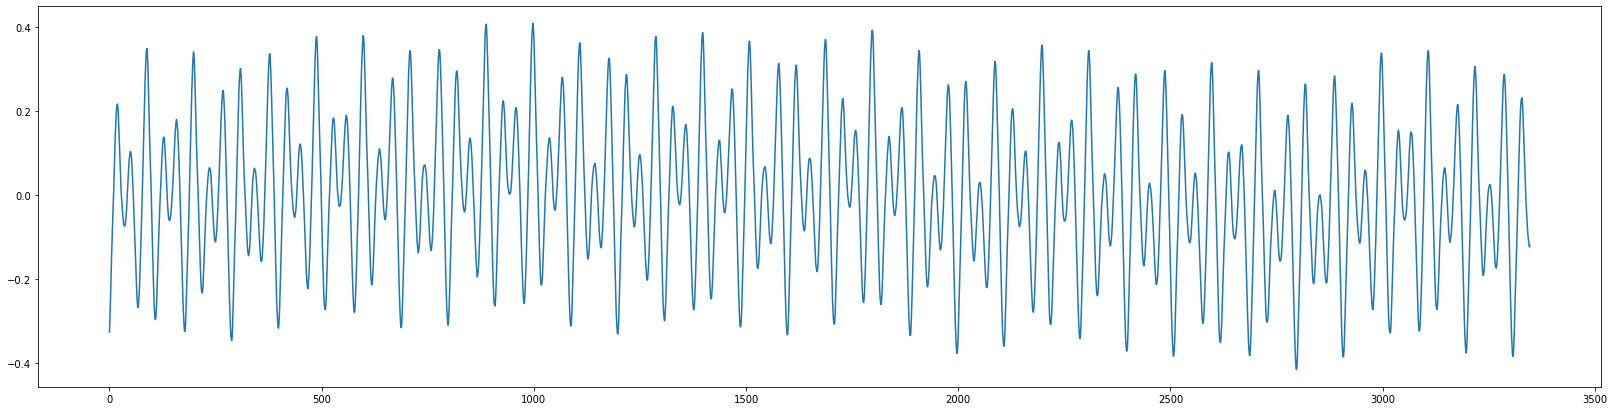

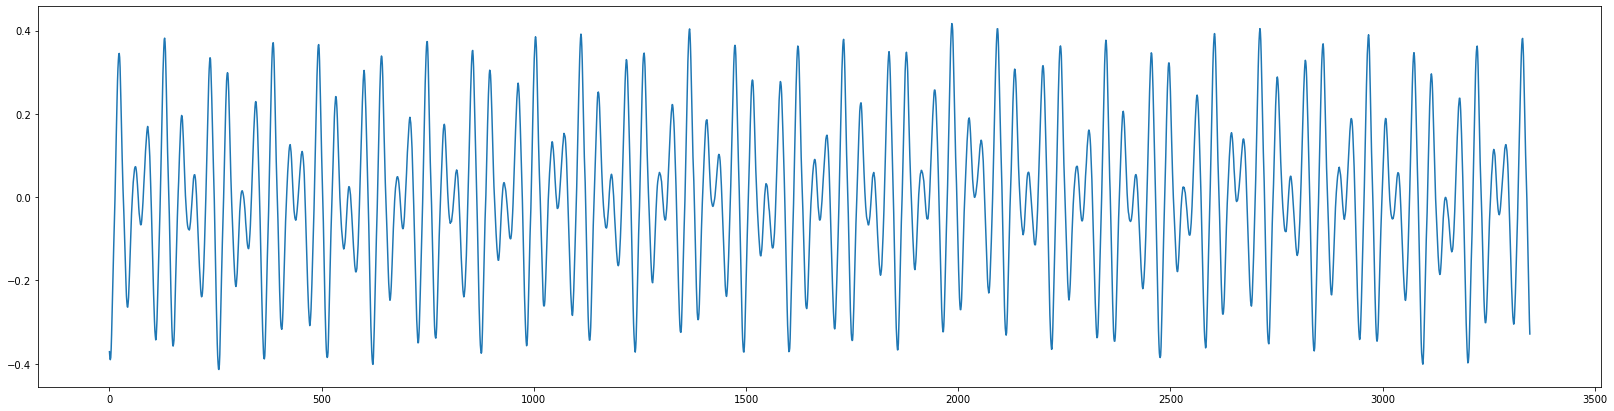

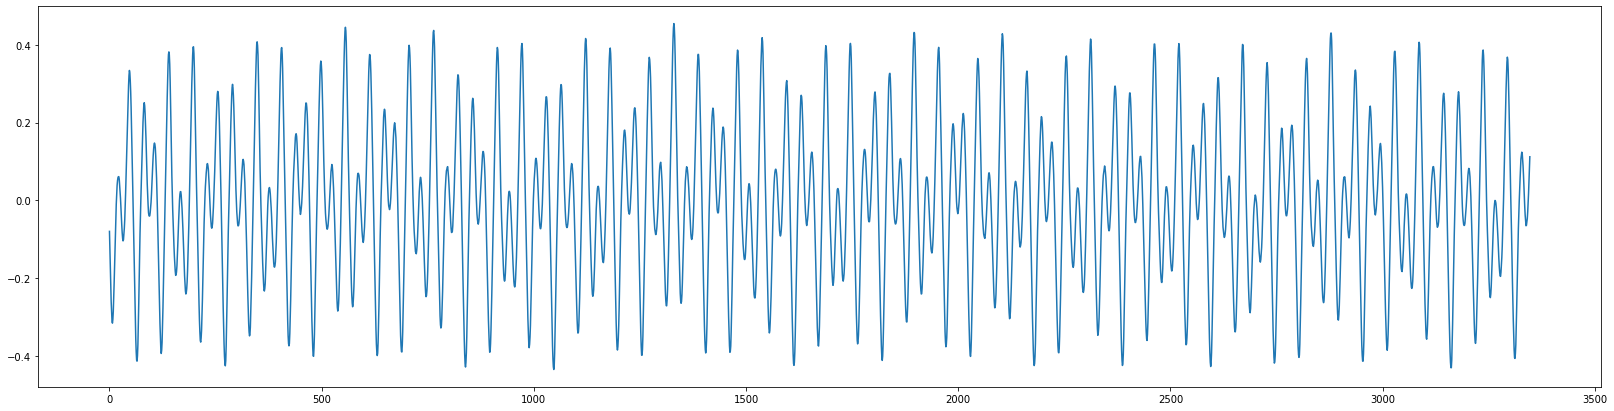

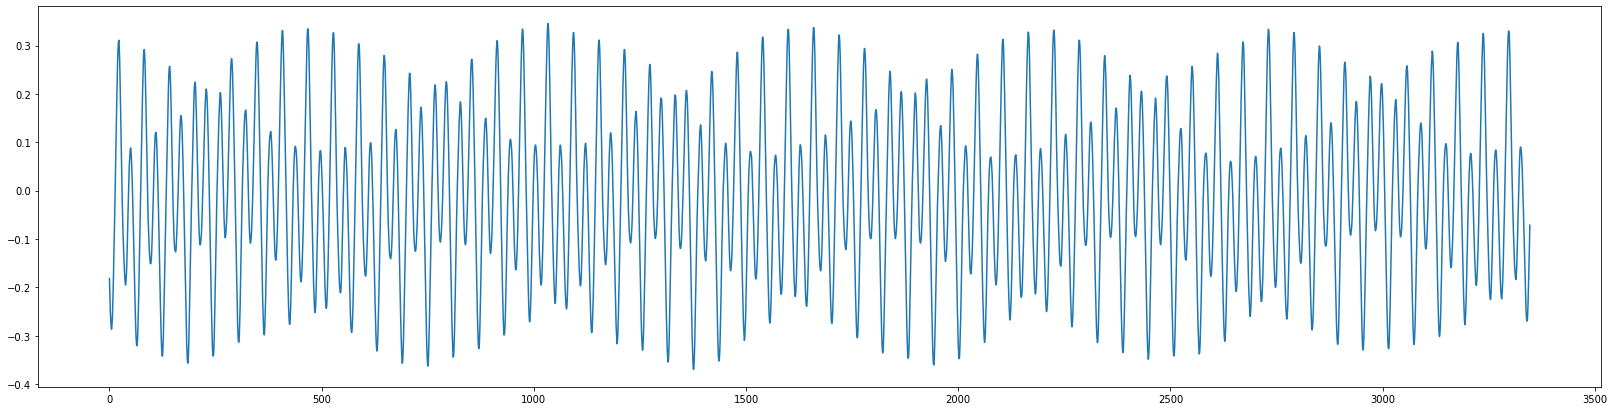

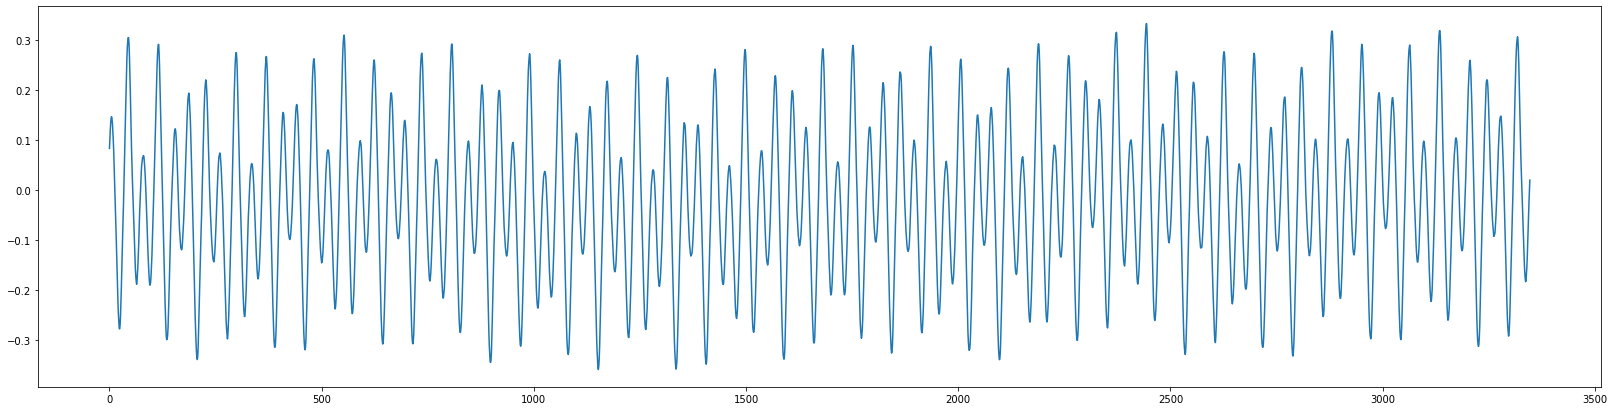

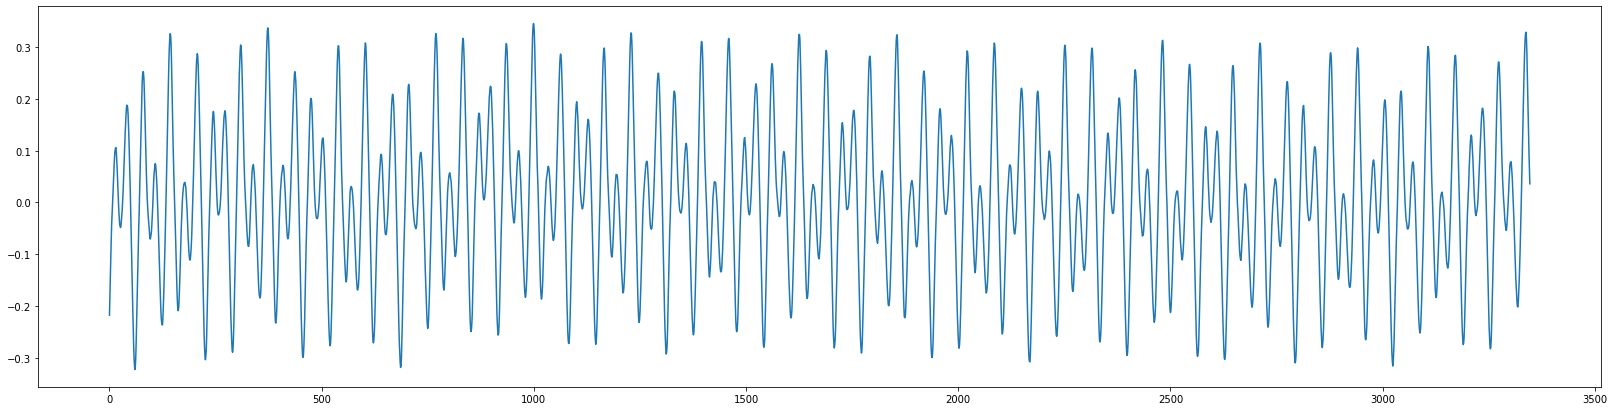

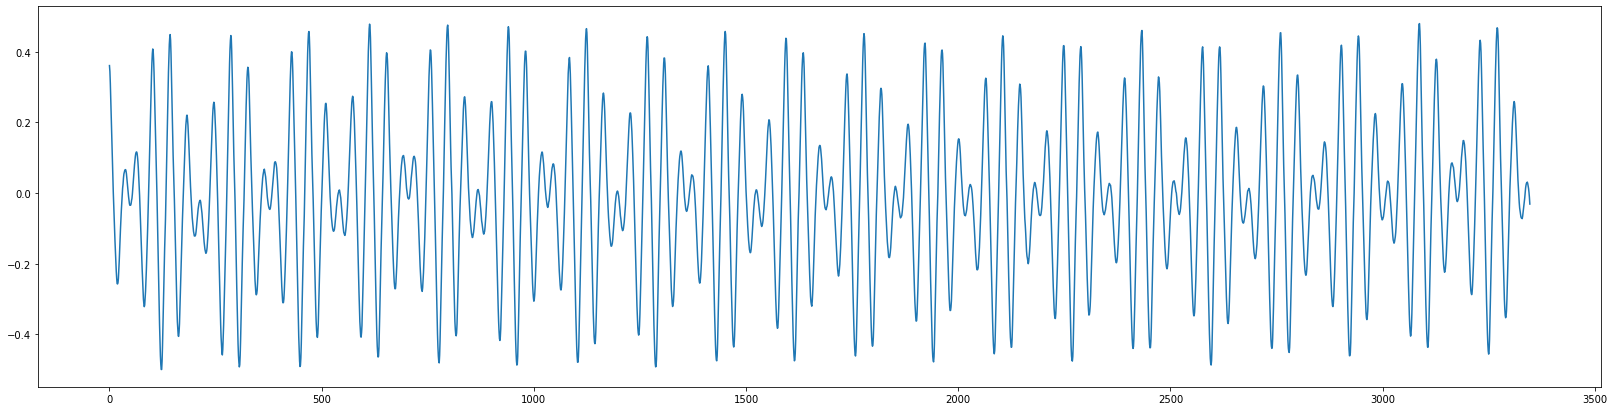

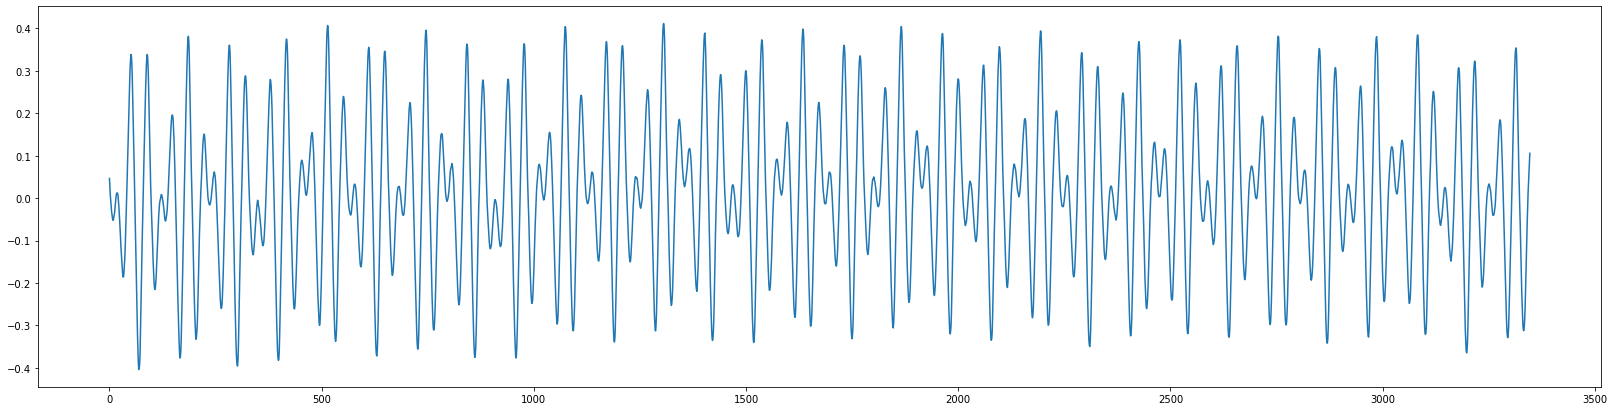

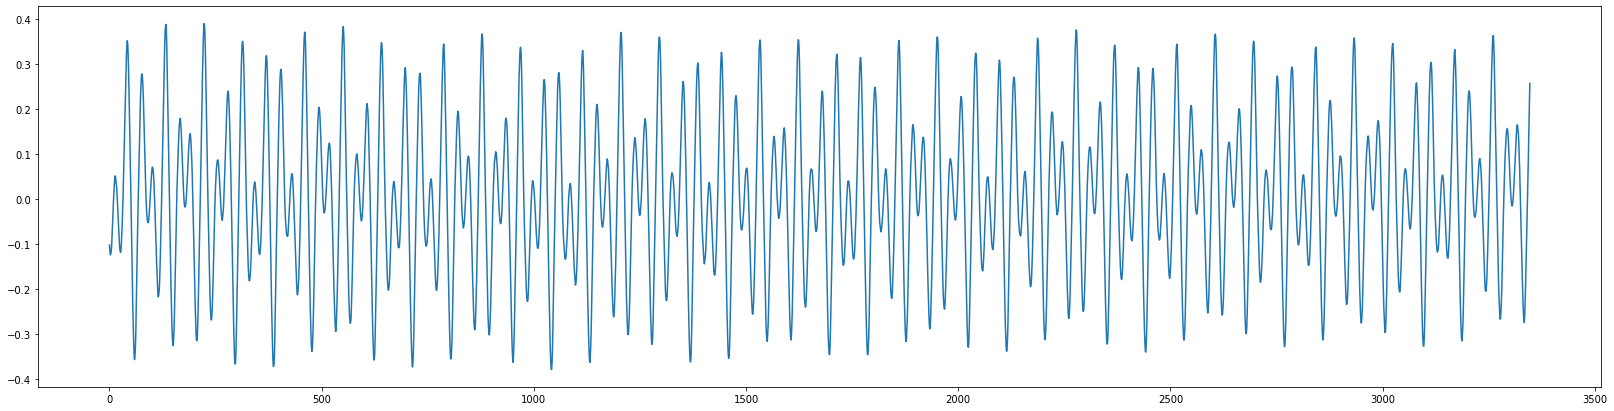

In [337]:
# plotando cada um dos intervalos encontrados
tones_sound_waves = [sound_wave[begin:end]
                     for begin, end in filtered_intervals]

for tone_sound_wave in tones_sound_waves:
    pp.figure(figsize=(28, 7))
    pp.plot(tone_sound_wave)
    pp.show()


O audio gravado pode ser descrito como:

$$
S(t) = \sum_{n=1}^{8} A_n \times \sin{ (\phi_n 2\pi t + \sigma_n)}
$$

Sendo $A$ a amplitude de cada frequência $n$, e $\sigma_n$ a fase de cada um dos sinais. Utilizando o seno da soma, podemos desenvolver essa expressão para:


$$
S(t) = \sum_{n=1}^{8} A_n [\sin{(\phi_n 2\pi t)}\cos{(\sigma_n)} + \sin{(\sigma_n)}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} [\underbrace{A_n \cos(\sigma_n)}_{x_{2n-1}}\sin{(\phi_n 2\pi t)}
 + \overbrace{A_n \sin{(\sigma_n)}}^{x_{2n}}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} x_{2n-1}\sin{(\phi_n 2\pi t)} + \sum_{n=1}^{8} x_{2n}\cos{(\phi_n2\pi t)}, \; A_n = \sqrt{x_{2n}^2 + x_{2n-1}^2}
$$

Logo assim podemos ver que teremos 16 equações com diferentes coeficientes para serem encontrados, o que podemos fazer aplicando a técnica de mínimos quadrados. Aqueles que tiverem as maiores amplitudes serão os relacionados ao digito que buscamos

In [338]:
#simplificação, ao invés de criarmos 16 funções diferentes podemos criar apenas essa
def mmq(time, n):
    frequency = int(n/2)
    val = DTMF_FREQUENCIES[frequency] * math.pi * 2 * time
    return math.sin(val) if (n % 2 == 0) else math.cos(val)


A = np.zeros(shape=(MINOR_INTERVAL_SIZE, 16))
for i in range(0, MINOR_INTERVAL_SIZE):
    for j in range(0, 16):
        A[i][j] = mmq(i * DELTA_T, j)


Utilizando as equações normais temos que $\hat{x}$ é uma solução para $ Ax = B <=> A^{T}A \hat{x} = A^{T}b$ 

In [339]:
def solve_mmq_system(A, B):
    A_T = A.T
    A_T_dot_A = A_T @ A
    A_T_dot_b = A_T @ B
    return np.linalg.solve(A_T_dot_A, A_T_dot_b).T[0]


In [341]:
def get_amplitude_array(coeficiente_matrix):
    return np.array([(coeficiente_matrix[i]**2 + coeficiente_matrix[i+1]**2)**(1/2) for i in range(0, 16, 2)])


def get_low_and_high_amplitude_array(amplitude_array):
    return amplitude_array[0:4], amplitude_array[4:8]


def get_max_frequency_idxs(low_freq_amplitude, high_freq_amplitude):
    return low_freq_amplitude.argmax(), high_freq_amplitude.argmax()


for tone_sound_wave in tones_sound_waves:
    X = solve_mmq_system(A, tone_sound_wave)
    amplitudes_array = get_amplitude_array(X)
    low, high = get_low_and_high_amplitude_array(amplitudes_array)
    low_max, high_max = get_max_frequency_idxs(low, high)
    print(f"{DTMF_LOW_FREQUENCIES[low_max]}Hz & {DTMF_HIGH_FREQUENCIES[high_max]}Hz : {DTMF_DICT[low_max][high_max]}")


697Hz & 1477Hz : 3
697Hz & 1336Hz : 2
852Hz & 1477Hz : 9
697Hz & 1209Hz : 1
770Hz & 1209Hz : 4
852Hz & 1209Hz : 7
852Hz & 1477Hz : 9
697Hz & 1477Hz : 3
697Hz & 1209Hz : 1
770Hz & 1336Hz : 5
941Hz & 1209Hz : *
941Hz & 1336Hz : 0
941Hz & 1477Hz : #
